# 🎯 Exclusive π⁰ Reconstruction — NPS Experiment (2023–2024)

## ✨ Physics Motivation

We aim to extract the **exclusive cross section** for the process:

$
e + p \rightarrow e' + \pi^0 + p'
$

in which:
- The scattered electron is detected in the **HMS**.
- The two photons from π⁰ decay (π⁰ → γγ) are detected in the **NPS**.
- We do **not detect the recoil proton**, so we will apply an **exclusive cut** based on the **missing mass = proton mass**.

---

## 📁 Data Summary

- **Experiment**: NPS run group (Sept 2023 – May 2024)
- **Input**: Skimmed ROOT files located at  
  `/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/pi0_skimmed/`
- **Event structure**: one electron in HMS and two neutral clusters in NPS


In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from vector import array as vec_array

# Physical constants
M_PROTON = 0.938  # GeV
M_PION0  = 0.135  # GeV

# Optional: Style
plt.style.use("seaborn-v0_8-poster")


In [3]:
# Load skimmed data file
file_path = "/home/ubuntu/nps_analysis/pi0_analysis/data/nps_hms_coin_skimmed_4398.root"
tree = uproot.open(file_path)["T"]

# Load branches
branches = tree.arrays([
    "T.hms.hEDTM_tdcTimeRaw", "T.hms.hTRIG4_tdcTimeRaw", "H.cal.etot", "H.cal.etotnorm",
    "H.cal.etottracknorm", "H.cal.etrack", "H.cal.etracknorm",
    "H.cer.npeSum", "H.gtr.dp", "H.gtr.th", "H.gtr.ph", "H.gtr.y", "H.gtr.p", 
    "H.gtr.px", "H.gtr.py", "H.gtr.pz", "H.gtr.x", "H.gtr.y", "NPS.cal.nclust", "NPS.cal.clusE",
    "NPS.cal.clusX", "NPS.cal.clusY", "NPS.cal.clusT"
])

tree.keys()

['Ndata.NPS.cal.clusE',
 'NPS.cal.clusE',
 'Ndata.NPS.cal.clusT',
 'NPS.cal.clusT',
 'Ndata.NPS.cal.clusX',
 'NPS.cal.clusX',
 'Ndata.NPS.cal.clusY',
 'NPS.cal.clusY',
 'H.cal.etot',
 'H.cal.etotnorm',
 'H.cal.etottracknorm',
 'H.cal.etrack',
 'H.cal.etracknorm',
 'H.cer.npeSum',
 'H.gtr.dp',
 'H.gtr.p',
 'H.gtr.ph',
 'H.gtr.px',
 'H.gtr.py',
 'H.gtr.pz',
 'H.gtr.th',
 'H.gtr.x',
 'H.gtr.y',
 'NPS.cal.nclust',
 'T.hms.hEDTM_tdcTimeRaw',
 'T.hms.hTRIG1_tdcTimeRaw',
 'T.hms.hTRIG2_tdcTimeRaw',
 'T.hms.hTRIG3_tdcTimeRaw',
 'T.hms.hTRIG4_tdcTimeRaw',
 'T.hms.hTRIG5_tdcTimeRaw',
 'T.hms.hTRIG6_tdcTimeRaw']

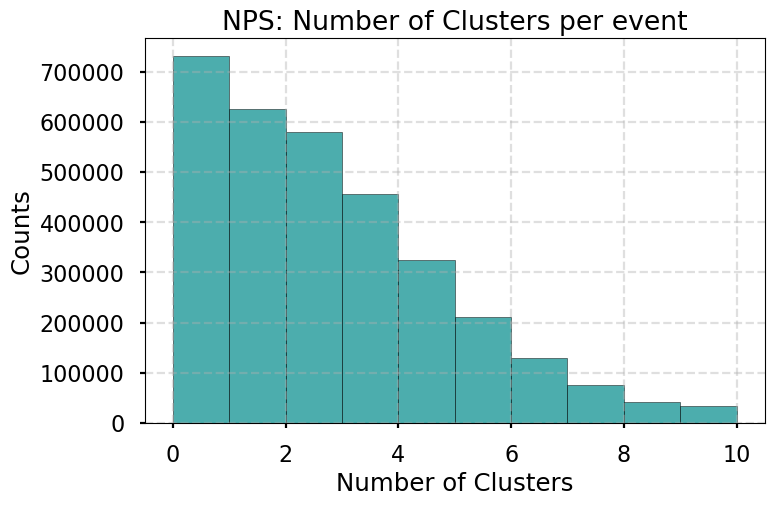

In [22]:
nclust = ak.to_numpy(branches["NPS.cal.nclust"])

plt.figure(figsize=(8, 5))
plt.hist(nclust, bins=np.arange(0, 10.5, 1), color="darkcyan", edgecolor="black", alpha=0.7)
plt.xlabel("Number of Clusters")
plt.ylabel("Counts")
plt.title("NPS: Number of Clusters per event")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


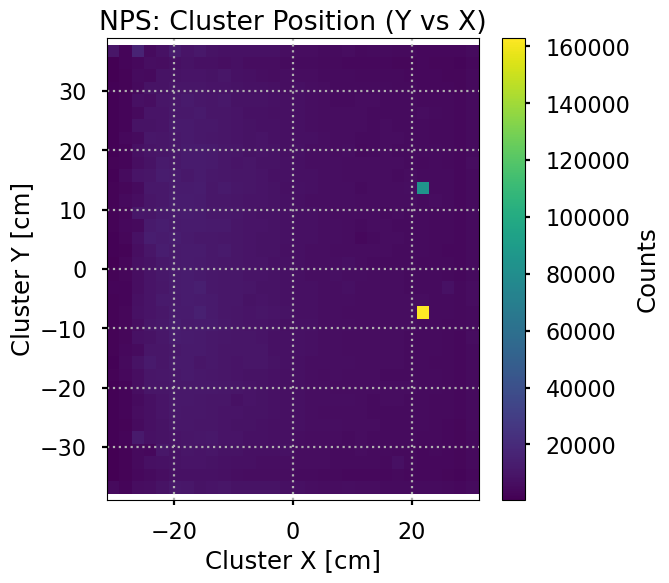

In [23]:
clusX = ak.to_numpy(ak.flatten(branches["NPS.cal.clusX"]))
clusY = ak.to_numpy(ak.flatten(branches["NPS.cal.clusY"]))

# clusX = ak.to_numpy((branches["NPS.cal.clusX"][:1]))
# clusY = ak.to_numpy((branches["NPS.cal.clusY"][:1]))

plt.figure(figsize=(6,6))
plt.hist2d(clusX, clusY, bins=(30,36), cmap='viridis')
plt.xlabel("Cluster X [cm]")
plt.ylabel("Cluster Y [cm]")
plt.title("NPS: Cluster Position (Y vs X)")
plt.colorbar(label="Counts")
plt.grid(True, linestyle=":")
plt.axis("equal")
plt.show()


In [6]:
clusX

array([ 20.98884291,   2.8744828 ,  17.19463612, ...,  14.04      ,
       -17.25477318, -18.36      ], shape=(8635667,))

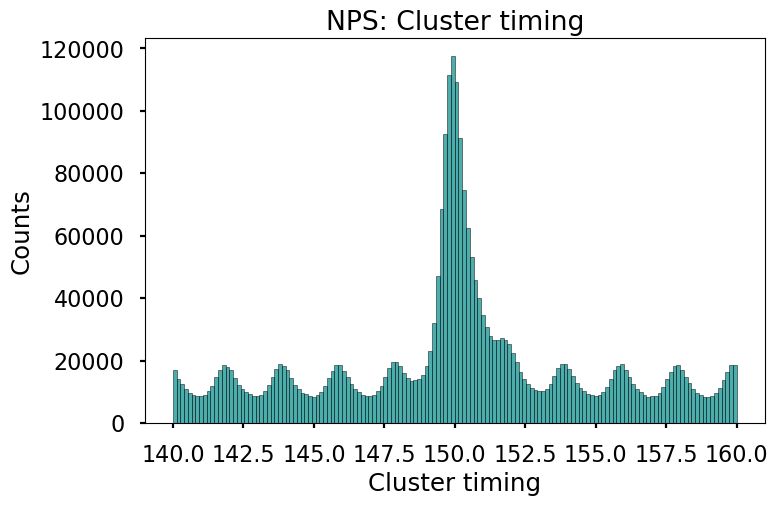

In [7]:
# includes all the cluster instances associated to the events.

clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))

plt.figure(figsize=(8,5))
plt.hist(clusT, bins=150, range=(140,160), color="darkcyan", edgecolor="black", alpha=0.7)
plt.xlabel("Cluster timing")
plt.ylabel("Counts")
plt.title("NPS: Cluster timing")
plt.show()

/tmp/ipykernel_32750/3991225391.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  event_times_np = np.array(event_times)  # Convert to NumPy array


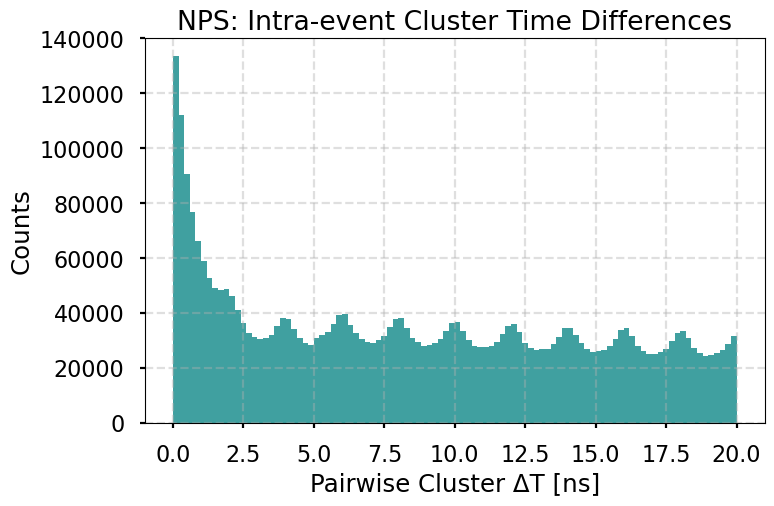

In [8]:
# plot pairwise time difference of the several instance of clusters associated to the same event.

clusT_all = branches["NPS.cal.clusT"]

time_diff = []

for event_times in clusT_all:
    event_times_np = np.array(event_times)  # Convert to NumPy array
    n = len(event_times_np)
    if n < 2:
        continue
    # Compute absolute pairwise time differences
    diffs = event_times_np[:, None] - event_times_np[None, :]
    triu = np.triu_indices(n, k=1)  # i < j to avoid duplicates and diagonal
    time_diff.extend(diffs[triu])

# Convert to NumPy array and plot
time_diff = np.array(time_diff)

plt.figure(figsize=(8,5))
plt.hist(time_diff, bins=100, range=(0, 20), color="teal", alpha=0.75)
plt.xlabel("Pairwise Cluster ΔT [ns]")
plt.ylabel("Counts")
plt.title("NPS: Intra-event Cluster Time Differences")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


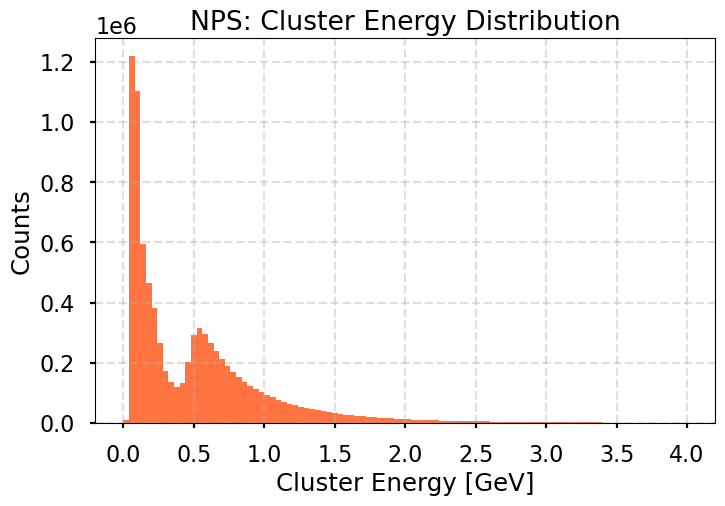

In [9]:
clusE = ak.to_numpy(ak.flatten(branches["NPS.cal.clusE"]))

plt.figure(figsize=(8,5))
plt.hist(clusE, bins=100, range=(0, 4), color="orangered", alpha=0.75)
plt.xlabel("Cluster Energy [GeV]")
plt.ylabel("Counts")
plt.title("NPS: Cluster Energy Distribution")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


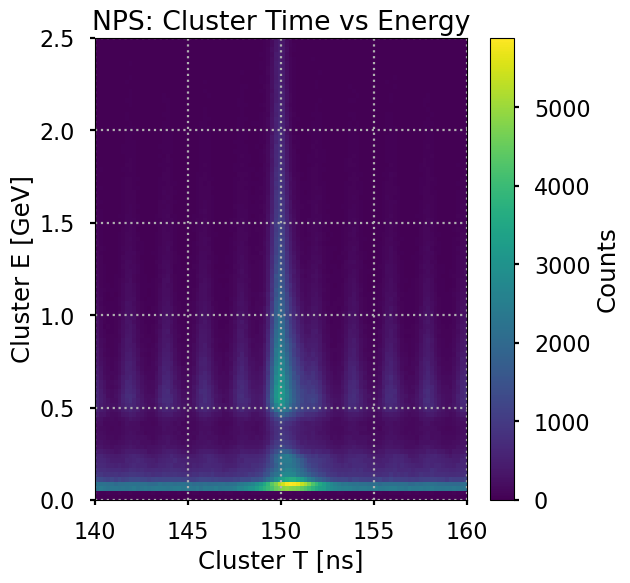

In [10]:
# Flatten jagged arrays to 1D NumPy arrays
clusT_flat = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
clusE_flat = ak.to_numpy(ak.flatten(branches["NPS.cal.clusE"]))

plt.figure(figsize=(6,6))
plt.hist2d(clusT_flat, clusE_flat,
           bins=[100, 100],
           range=[[140, 160], [0, 2.5]],
           cmap='viridis')
plt.xlabel("Cluster T [ns]")
plt.ylabel("Cluster E [GeV]")
plt.title("NPS: Cluster Time vs Energy")
plt.colorbar(label="Counts")
plt.grid(True, linestyle=":")
plt.show()


In [ ]:
def reconstruct_pi0_mass(event):
    energies = event["NPS.cal.clusE"]
    xs = event["NPS.cal.clusX"]
    ys = event["NPS.cal.clusY"]

    if len(energies) < 2:
        return None  # Not enough clusters

    # Take the two highest-energy clusters
    idx = np.argsort(energies)[-2:]
    e1, e2 = energies[idx[0]], energies[idx[1]]
    x1, y1 = xs[idx[0]], ys[idx[0]]
    x2, y2 = xs[idx[1]], ys[idx[1]]

    # Assume vertex at origin, NPS at fixed z
    z_nps = 4.07  # meters, placeholder
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    u1 = r1 / np.linalg.norm(r1)
    u2 = r2 / np.linalg.norm(r2)

    # Photon 3-momenta
    p1 = e1 * u1
    p2 = e2 * u2
    total_E = e1 + e2
    total_p = p1 + p2
    m2 = total_E**2 - np.dot(total_p, total_p)
    return np.sqrt(m2) if m2 > 0 else 0.0


<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_259648/3976835230.py:11: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
/tmp/ipykernel_259648/3976835230.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Reconstructed $\pi^0$ Mass from Two Photons")


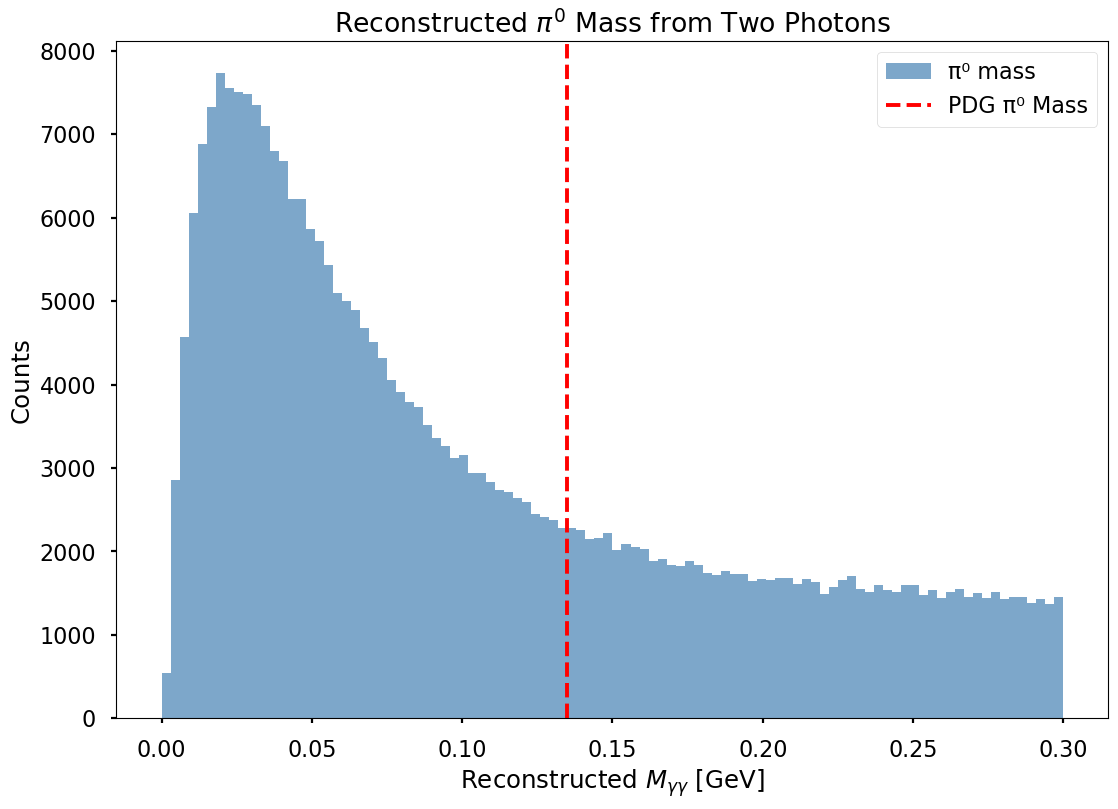

In [ ]:
pi0_masses = []

for evt in branches:
    m = reconstruct_pi0_mass(evt)
    if m:
        pi0_masses.append(m)

# Plot
plt.figure(figsize=(6,6))
plt.hist(pi0_masses, bins=100, range=(0, 0.3), color="steelblue", alpha=0.7, label="π⁰ mass")
plt.axvline(M_PION0, color='red', linestyle='--', label='PDG π⁰ Mass')
plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.title("Reconstructed $\pi^0$ Mass from Two Photons")
plt.show()


In [11]:
# much faster (around 4x) with numba then the prev cells using just plain python

import numba as nb
import numpy as np

@nb.njit
def reconstruct_pi0_mass_fast(e1, e2, x1, y1, x2, y2, z_nps=4.07):
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    norm1 = np.sqrt(np.sum(r1 ** 2))
    norm2 = np.sqrt(np.sum(r2 ** 2))
    u1 = r1 / norm1
    u2 = r2 / norm2
    p1 = e1 * u1
    p2 = e2 * u2
    total_E = e1 + e2
    total_p = p1 + p2
    m2 = total_E**2 - np.dot(total_p, total_p)
    return np.sqrt(m2) if m2 > 0 else 0.0


<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_32750/1287418248.py:17: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
/tmp/ipykernel_32750/1287418248.py:20: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Reconstructed $\pi^0$ Mass from Two Photons")
/tmp/ipykernel_32750/1287418248.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e = np.array(event["NPS.cal.clusE"])
/tmp/ipykernel_32750/1287418248.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=Fals

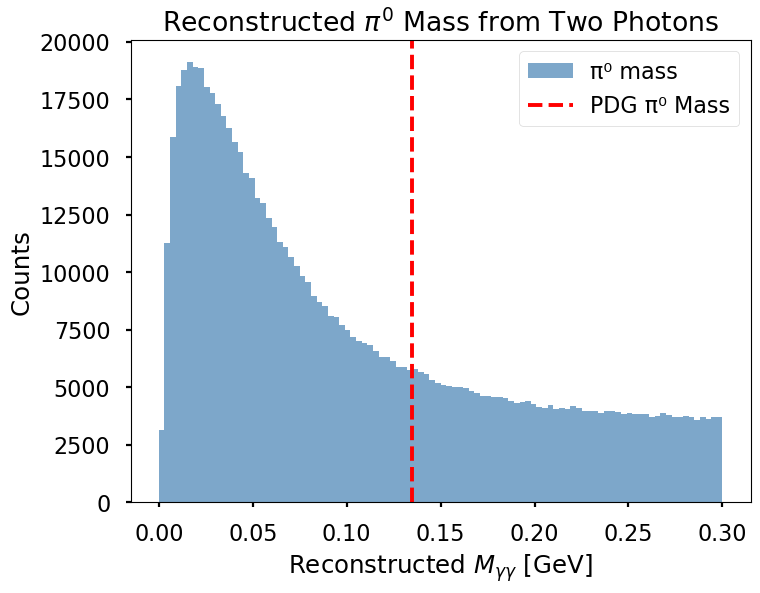

In [12]:
masses = []
for event in branches:  # loop over awkward array
    e = np.array(event["NPS.cal.clusE"])
    x = np.array(event["NPS.cal.clusX"])
    y = np.array(event["NPS.cal.clusY"])
    if len(e) < 2:
        continue
    idx = np.argsort(e)[-2:]
    masses.append(reconstruct_pi0_mass_fast(e[idx[0]], e[idx[1]],
                                            x[idx[0]], y[idx[0]],
                                            x[idx[1]], y[idx[1]]))
    
# Plot
plt.figure(figsize=(8,6))
plt.hist(masses, bins=100, range=(0, 0.3), color="steelblue", alpha=0.7, label="π⁰ mass")
plt.axvline(M_PION0, color='red', linestyle='--', label='PDG π⁰ Mass')
plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.title("Reconstructed $\pi^0$ Mass from Two Photons")
plt.show()


In [ ]:
# HMS time per event
hmsT = branches["T.hms.hEDTM_tdcTimeRaw"]
clusT = branches["NPS.cal.clusT"]

# Compute deltaT (cluster time - HMS time) per cluster
deltaT = clusT - hmsT  # This uses broadcasting via awkward arrays

# Coincidence window: 149–151 ns (~±1 ns from peak)
signal_mask = (deltaT > 149) & (deltaT < 151)

# Background windows (like your bgLo/bgHi)
bg_lo_mask = (deltaT > 113) & (deltaT < 142.5)
bg_hi_mask = (deltaT > 171.5) & (deltaT < 180)



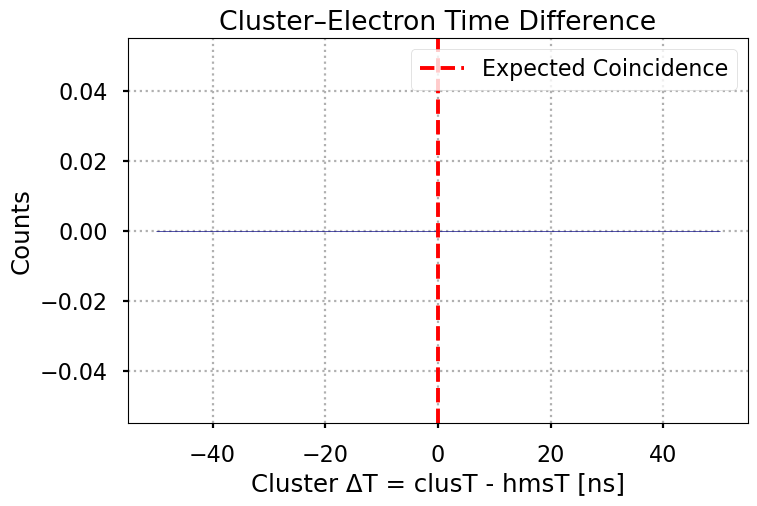

In [ ]:
deltaT_flat = ak.to_numpy(ak.flatten(deltaT))
plt.figure(figsize=(8,5))
plt.hist(deltaT_flat, bins=10, range=(-50, 50), histtype='step', color='navy')
plt.xlabel("Cluster ΔT = clusT - hmsT [ns]")
plt.ylabel("Counts")
plt.title("Cluster–Electron Time Difference")
plt.grid(True, linestyle=":")
plt.axvline(0, color="red", linestyle="--", label="Expected Coincidence")
plt.legend()
plt.show()

# Opening Angle Calculation

The neutral pion decays via:

$$
\pi^0 \to \gamma\gamma
$$

Using four-momentum conservation:

$$
P_\pi^2 = (P_{\gamma_1} + P_{\gamma_2})^2
$$

Expanding the right-hand side:

$$
m_\pi^2 = P_{\gamma_1}^2 + P_{\gamma_2}^2 + 2P_{\gamma_1}^\mu P_{\gamma_2\mu}
$$

Since photons are massless, $ P_{\gamma_i}^2 = 0 $, so:

$$
m_\pi^2 = 2P_{\gamma_1}^\mu P_{\gamma_2\mu}
$$

Using the inner product of four-vectors:

$$
m_\pi^2 = 2 \left( E_{\gamma_1}E_{\gamma_2} - \vec{p}_{\gamma_1} \cdot \vec{p}_{\gamma_2} \right)
$$

The dot product can be written in terms of the opening angle $\theta$ between the two photons:

$$
\vec{p}_{\gamma_1} \cdot \vec{p}_{\gamma_2} = |\vec{p}_{\gamma_1}||\vec{p}_{\gamma_2}|\cos\theta
$$

Since $ |\vec{p}_{\gamma_i}| = E_{\gamma_i} $ for photons:

$$
m_\pi^2 = 2E_{\gamma_1}E_{\gamma_2}(1 - \cos\theta)
$$

Using the identity $( 1 - \cos\theta = 2\sin^2(\theta/2) )$, we get:

$$
m_\pi^2 = 4E_{\gamma_1}E_{\gamma_2} \sin^2(\theta/2)
$$

Solving for the opening angle $\theta$:

$$
\theta = 2 \sin^{-1}\left( \frac{m_\pi}{\sqrt{4E_{\gamma_1}E_{\gamma_2}}} \right)
$$

This relation can be used as a **kinematic constraint** to validate whether a photon pair is consistent with originating from a real $ \pi^0 $ decay.


In [54]:
# function to reconcstruct invariant neutral pion mass taking into account the opening angle

import numba as nb
import numpy as np
from tqdm import tqdm

M_PION0  = 0.135  # GeV

@nb.njit
def reconstruct_pi0_mass_fast_w_opening_angle(e1, e2, x1, y1, x2, y2, z_nps=407): # z_nps in cm
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    norm1 = np.sqrt(np.sum(r1 ** 2))
    norm2 = np.sqrt(np.sum(r2 ** 2))
    u1 = r1 / norm1
    u2 = r2 / norm2
    p1 = e1 * u1
    p2 = e2 * u2
    total_E = e1 + e2
    total_p = p1 + p2

    # Opening angle cut
    theta_ideal = 2 * np.arcsin(M_PION0 / np.sqrt(4 * e1 * e2))
    dot = np.dot(u1, u2)
    dot = min(1.0, max(-1.0, dot))  # Clamp to avoid NaNs from rounding errors
    theta_data = np.arccos(dot)


    # block_dim = 0.0205 # 2.05 x 2.05 cm^2 PbWO4 scintillator block
    theta_tolerance_rad = 0.01 # considering a cluster size of 4x4 blocks and the distance of NPS of 4.07 m. theta = (4x0.0205)/nps_distance

    if np.abs(theta_data - theta_ideal) < theta_tolerance_rad:  # radians
        m2 = total_E**2 - np.dot(total_p, total_p)
        return np.sqrt(m2) if m2 > 0 else 0.0
    else:
        return 0.0  # Or np.nan if you prefer masking out

In [55]:
# masses = []
# for event in branches:  # loop over awkward array
#     e = np.asarray(event["NPS.cal.clusE"])
#     x = np.asarray(event["NPS.cal.clusX"])
#     y = np.asarray(event["NPS.cal.clusY"])
#     if len(e) < 2:
#         continue
#     idx = np.argsort(e)[-2:]
#     masses.append(reconstruct_pi0_mass_fast_w_opening_angle(e[idx[0]], e[idx[1]],
#                                             x[idx[0]], y[idx[0]],
#                                             x[idx[1]], y[idx[1]]))
    
from tqdm import tqdm

masses = []
for event in tqdm(branches, desc="Processing events"):
    e = np.asarray(event["NPS.cal.clusE"])
    x = np.asarray(event["NPS.cal.clusX"])
    y = np.asarray(event["NPS.cal.clusY"])
    if len(e) < 2:
        continue
    idx = np.argsort(e)[-2:]
    masses.append(reconstruct_pi0_mass_fast_w_opening_angle(
        e[idx[0]], e[idx[1]],
        x[idx[0]], y[idx[0]],
        x[idx[1]], y[idx[1]]
    ))


Processing events:  20%|█▉        | 637890/3222394 [01:35<06:28, 6652.91it/s]


KeyboardInterrupt: 

<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1074/119554853.py:4: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
/tmp/ipykernel_1074/119554853.py:7: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Reconstructed $\pi^0$ Mass from Two Photons")


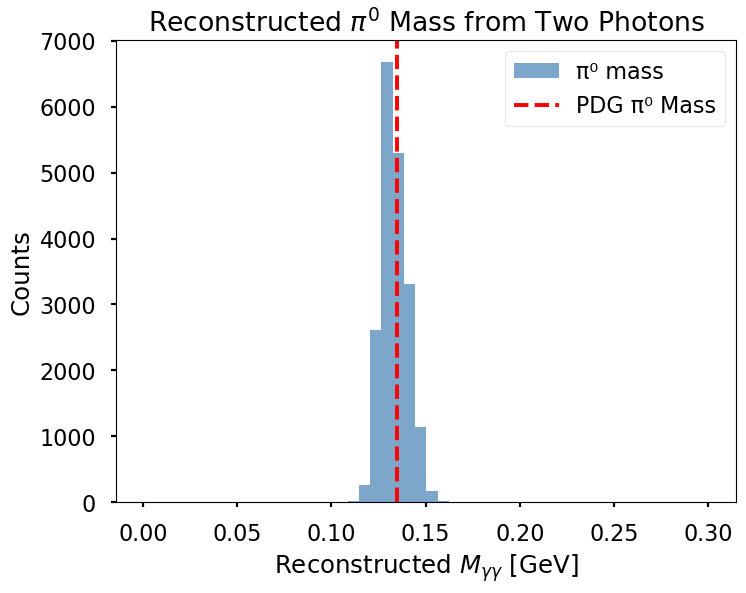

In [56]:
plt.figure(figsize=(8,6))
plt.hist(masses, bins=50, range=(0.001, 0.3), color="steelblue", alpha=0.7, label="π⁰ mass")
plt.axvline(M_PION0, color='red', linestyle='--', label='PDG π⁰ Mass')
plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.title("Reconstructed $\pi^0$ Mass from Two Photons")
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:30: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1074/2489511093.py:16: SyntaxWarning: invalid escape sequence '\p'
  density=True, color="steelblue", alpha=0.6, label="Reconstructed $\pi^0$ Mass"
/tmp/ipykernel_1074/2489511093.py:25: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(0.13498, color='red', linestyle='--', label='PDG $\pi^0$ Mass (134.98 MeV)')
/tmp/ipykernel_1074/2489511093.py:28: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]", fontsize=14)
/tmp/ipykernel_1074/2489511093.py:30: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Reconstruct

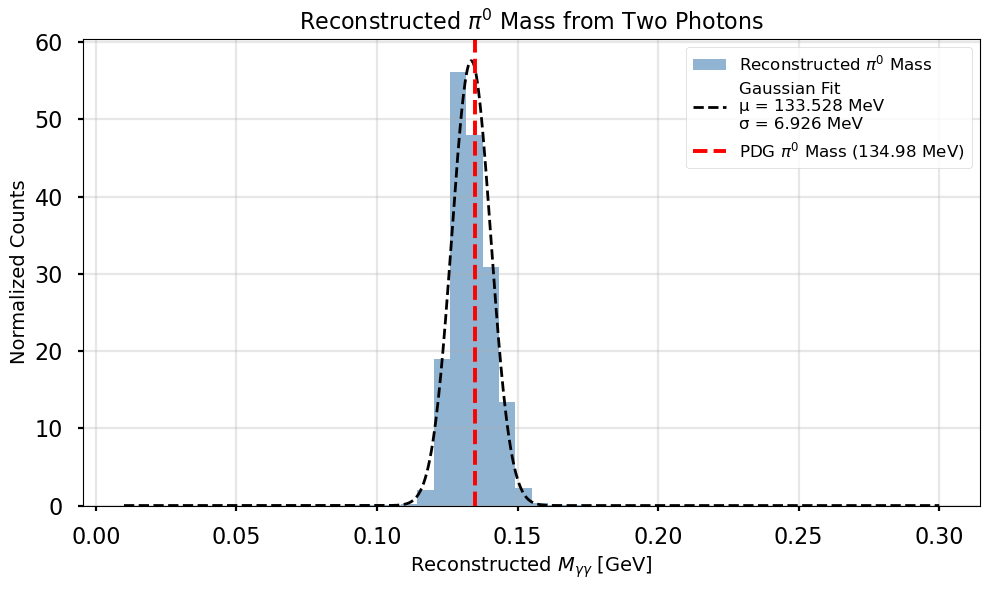

Fitted Mean: 0.1335 GeV
Fitted Std Dev: 0.0069 GeV


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming `masses` is your array of reconstructed π⁰ masses
masses_clean = np.array(masses)
masses_clean = masses_clean[(masses_clean > 0.01) & (masses_clean < 0.3)]

# Fit a Gaussian
mu, std = norm.fit(masses_clean)

# Plot histogram
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(
    masses_clean, bins=50, range=(0.01, 0.3), 
    density=True, color="steelblue", alpha=0.6, label="Reconstructed $\pi^0$ Mass"
)

# Plot Gaussian fit
x = np.linspace(0.01, 0.3, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2, label=f'Gaussian Fit\nμ = {1000*mu:.3f} MeV\nσ = {1000*std:.3f} MeV')

# PDG mass line
plt.axvline(0.13498, color='red', linestyle='--', label='PDG $\pi^0$ Mass (134.98 MeV)')

# Labels and legend
plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]", fontsize=14)
plt.ylabel("Normalized Counts", fontsize=14)
plt.title("Reconstructed $\pi^0$ Mass from Two Photons", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Fitted Mean: {mu:.4f} GeV")
print(f"Fitted Std Dev: {std:.4f} GeV")


In [ ]:
# trying out helper functions from Josh's script

import numpy as np

def normalize_peaks(y, win, frac):
    y = np.array(y)
    out = y.copy()
    ymax = np.max(y)
    thr = frac * ymax
    cand = [i for i in range(1, len(y)-1) if y[i] > y[i-1] and y[i] > y[i+1] and y[i] > thr]
    
    peaks = []
    for p in cand:
        if not peaks or p - peaks[-1] >= win:
            peaks.append(p)
        elif y[p] > y[peaks[-1]]:
            peaks[-1] = p

    if not peaks:
        return out

    avg = np.mean([y[p] for p in peaks])
    h = win // 2
    for p in peaks:
        scl = avg / y[p]
        for i in range(max(0, p-h), min(len(y), p+h+1)):
            w = 1.0 - abs(i - p) / (win + 1)
            out[i] = y[i] * (1 - w) + (y[i] * scl) * w

    return out


In [ ]:
nclust_temp = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))

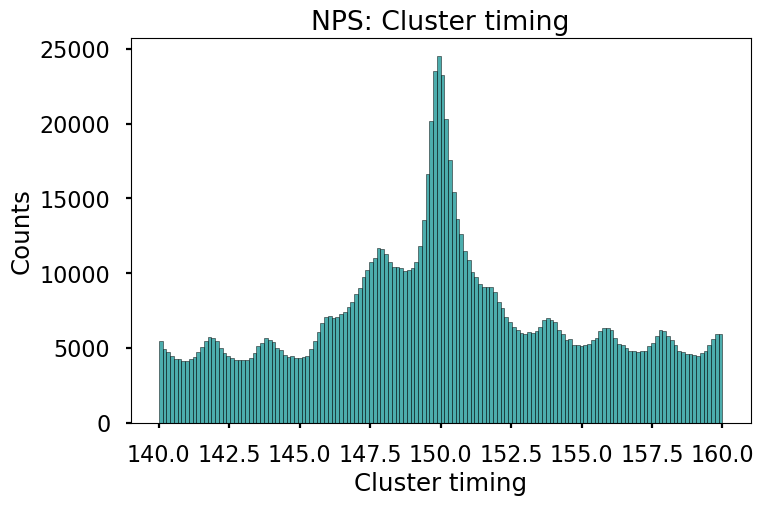

In [ ]:
temp1 = normalize_peaks(nclust_temp, 10, 0.75)
plt.figure(figsize=(8,5))
plt.hist(temp1, bins=150, range=(140,160), color="darkcyan", edgecolor="black", alpha=0.7)
plt.xlabel("Cluster timing")
plt.ylabel("Counts")
plt.title("NPS: Cluster timing")
plt.show()

In [ ]:
import uproot
import pandas as pd

# Path to your skimmed ROOT file
root_file = "/home/ubuntu/nps_analysis/pi0_analysis/data/nps_hms_coin_skimmed_4487.root"

# Open the file
file = uproot.open(root_file)
tree = file["T"]  # or whatever your TTree name is

# Select the branches you want
branches = [
    "T.hms.hEDTM_tdcTimeRaw",
    "H.gtr.dp", "H.cal.etotnorm", "H.cer.npeSum",
    "H.gtr.th", "H.gtr.ph", "H.gtr.p",
    "NPS.cal.nclust",
    "NPS.cal.clusE", "NPS.cal.clusX", "NPS.cal.clusY", "NPS.cal.clusT"
]

# Load into DataFrame
df = tree.arrays(branches, library="pd")


# Include Josh's good cluster cuts

# Background subtraction tests

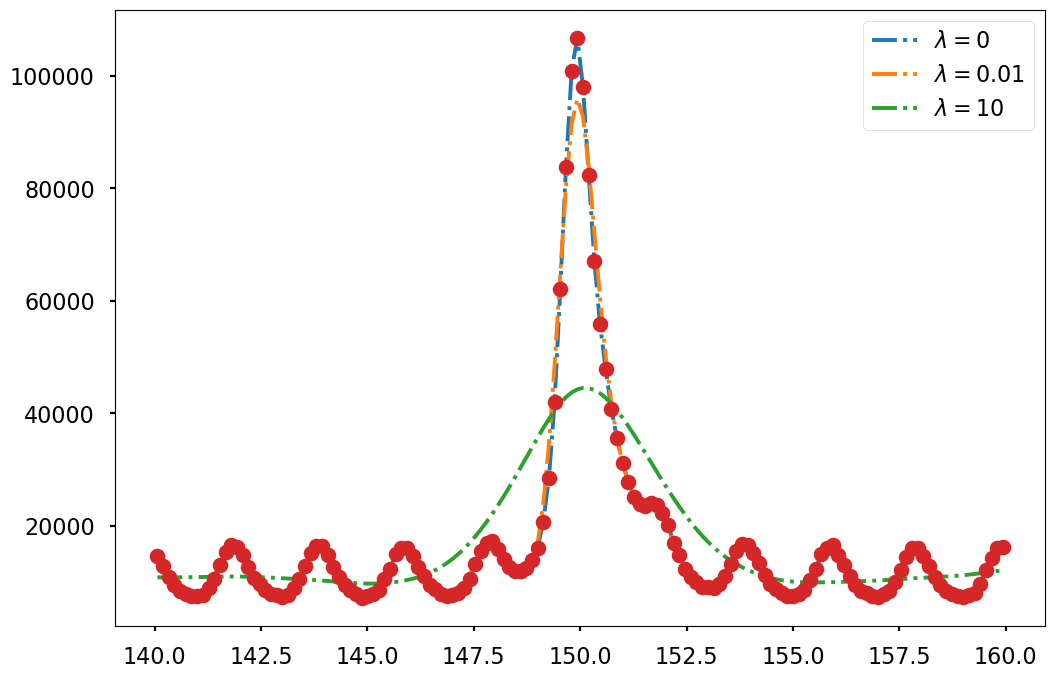

In [ ]:
import numpy as np
from scipy.interpolate import make_smoothing_spline
import matplotlib.pyplot as plt

clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
hist_signal,bin_edges = np.histogram(clusT, bins=150, range=(140,160))
# === Bin centers ===
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(12,8))
for lam in [0, 0.01, 10]:
    spl = make_smoothing_spline(bin_centers, hist_signal, lam=lam)
    plt.plot(bin_centers, spl(bin_centers), '-.', label=fr'$\lambda=${lam}')
plt.plot(bin_centers, hist_signal, 'o')
plt.legend()    
plt.show()

In [38]:
import numpy as np
from scipy.interpolate import make_splprep
import matplotlib.pyplot as plt

clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
hist_signal,bin_edges = np.histogram(clusT, bins=150, range=(140,160))
# === Bin centers ===
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(12,8))
plt.plot(bin_centers, make_splprep(bin_centers, hist_signal, s=0)(bin_centers), '-', label='s=0')
plt.plot(bin_centers, hist_signal, 'o')
plt.legend()
plt.show()

TypeError: make_splprep() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

<Figure size 1200x800 with 0 Axes>

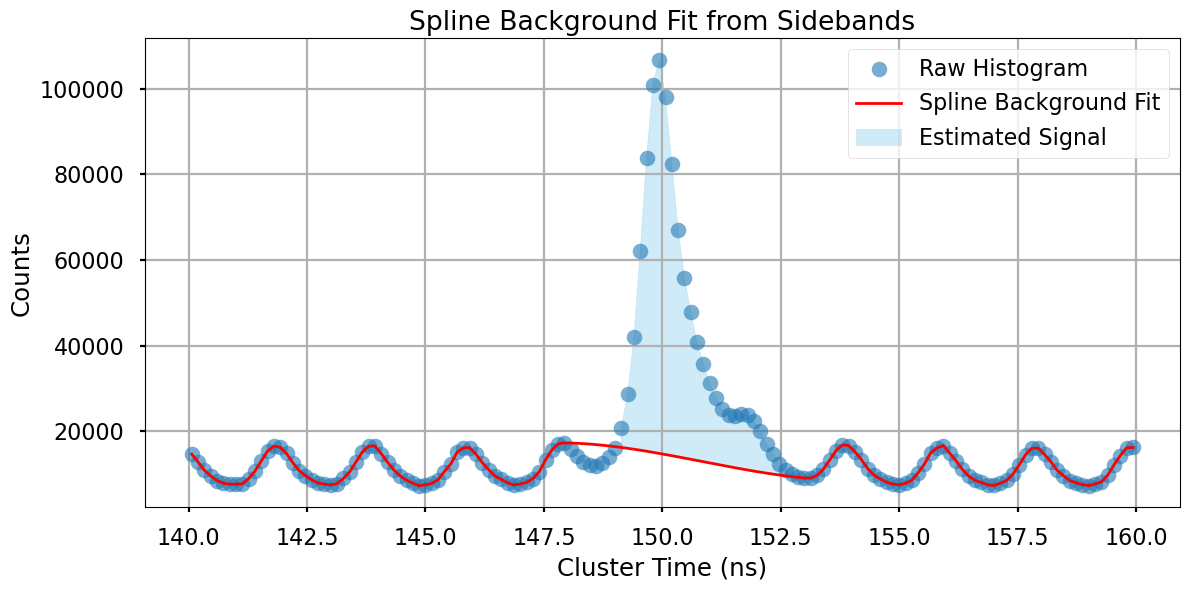

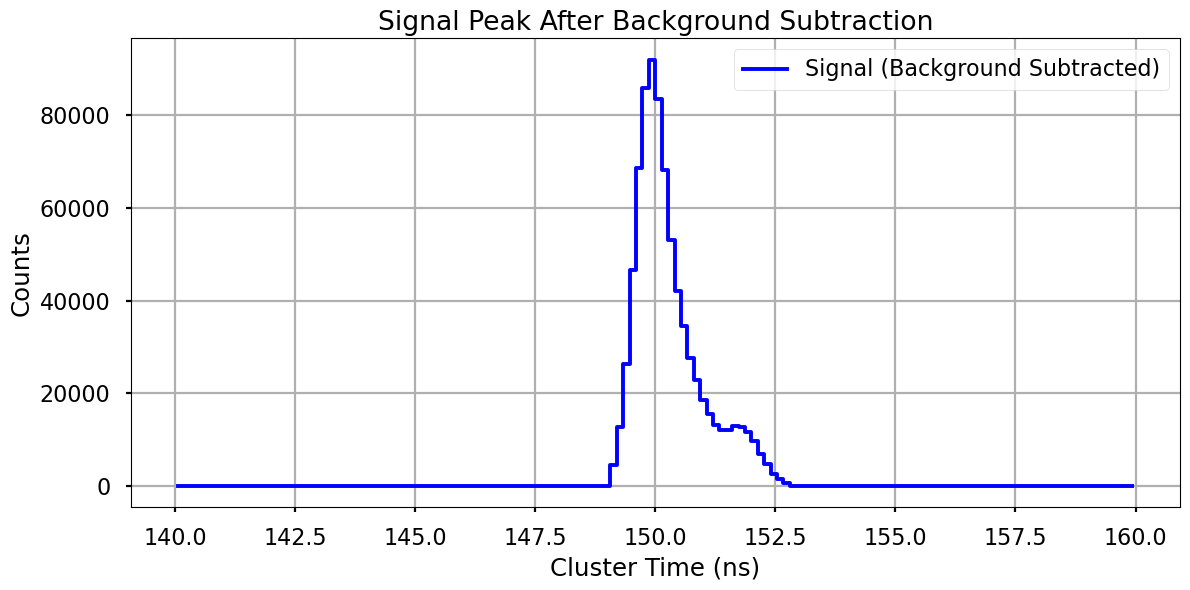

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import awkward as ak

# === Load data and histogram ===
clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
hist_signal, bin_edges = np.histogram(clusT, bins=150, range=(140, 160))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# === Define sidebands ===
sideband_mask = ((bin_centers >= 140) & (bin_centers <= 148)) | ((bin_centers >= 153) & (bin_centers <= 160))
x_sideband = bin_centers[sideband_mask]
y_sideband = hist_signal[sideband_mask]

# === Fit spline to sidebands ===
spline_fit = UnivariateSpline(x_sideband, y_sideband, s=2)  # Adjust s as needed for smoothing

# === Predict full background ===
background_estimate = spline_fit(bin_centers)

# === Subtract background ===
signal_subtracted = hist_signal - background_estimate
signal_subtracted[signal_subtracted < 0] = 0  # Avoid negatives

# === Plot: Raw + Fit ===
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, hist_signal, 'o', label='Raw Histogram', alpha=0.6)
plt.plot(bin_centers, background_estimate, '-', label='Spline Background Fit', color='red', linewidth=2)
plt.fill_between(bin_centers, background_estimate, hist_signal, where=(hist_signal > background_estimate), 
                 color='skyblue', alpha=0.4, label='Estimated Signal')
plt.xlabel("Cluster Time (ns)")
plt.ylabel("Counts")
plt.title("Spline Background Fit from Sidebands")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot: Background Subtracted Signal ===
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, signal_subtracted, drawstyle='steps-mid', color='blue', label='Signal (Background Subtracted)')
plt.xlabel("Cluster Time (ns)")
plt.ylabel("Counts")
plt.title("Signal Peak After Background Subtraction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


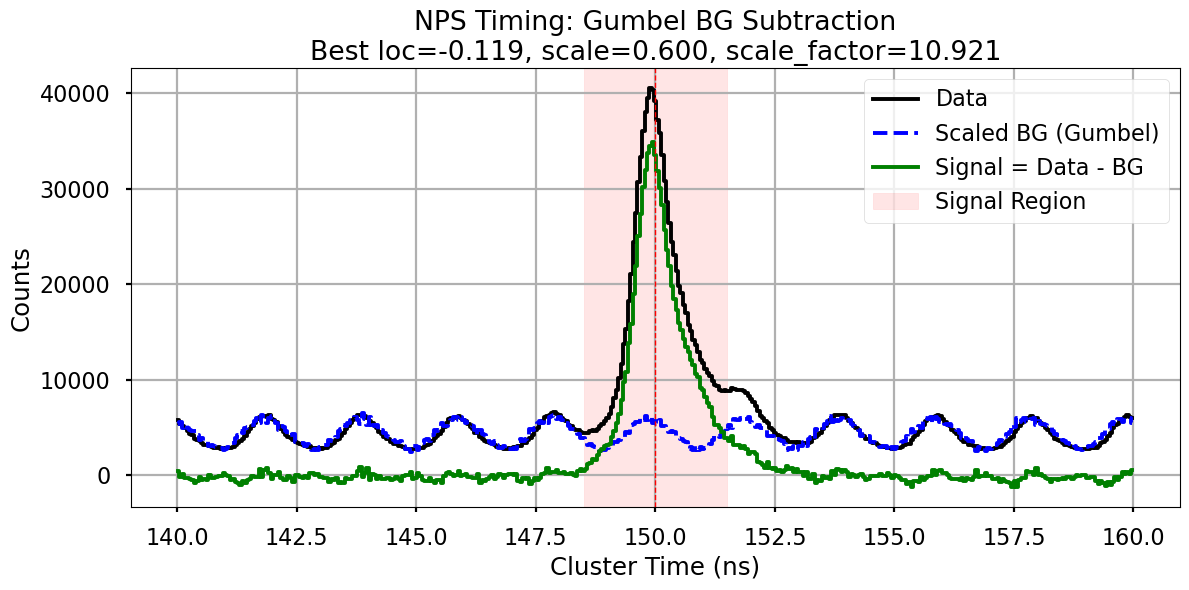

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
from scipy.interpolate import interp1d


# === Load real data ===
# Replace this with your real NPS cluster time data
# Example: cluster_times = branches["NPS.cal.clusT"][has_two_clust].to_numpy()
# cluster_times = np.loadtxt("your_data_times.txt")  # Replace with your actual data source
clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
# === Parameters ===
beam_bucket_spacing = 2.0        # ns
n_buckets = 200
true_peak_time = 150.0           # ns
n_bg_per_bucket = 16000
loc = -0.119                        # Gumbel mean offset
scale = 0.6                      # Gumbel width

# === Histogram bins ===
bins = np.linspace(140, 160, 400)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# === Simulate Gumbel background ===
def gumbel_samples(t_center, size):
    return t_center + gumbel_r.rvs(loc=loc, scale=scale, size=size)

bg_times = []
for i in range(-n_buckets, n_buckets + 1):
    t_bucket = true_peak_time + i * beam_bucket_spacing
    bg_times.extend(gumbel_samples(t_bucket, n_bg_per_bucket))
bg_times = np.array(bg_times)

# === Normalize background using sidebands ===
hist_data, _ = np.histogram(clusT, bins=bins)
hist_bg, _ = np.histogram(bg_times, bins=bins)

# Define sidebands (away from signal region)
sideband_mask = ((bin_centers < 148.5) | (bin_centers > 151.5))

# Calculate scale factor using sidebands
data_sb_sum = np.sum(hist_data[sideband_mask])
sim_sb_sum = np.sum(hist_bg[sideband_mask])
scale_factor = data_sb_sum / sim_sb_sum if sim_sb_sum > 0 else 0

# Scale background
scaled_bg = hist_bg * scale_factor

# === Background Subtracted Histogram ===
subtracted = hist_data - scaled_bg

# # === Plotting ===
# plt.figure(figsize=(8, 5))

# plt.step(bin_centers, hist_data, where='mid', color='black', label='Data')
# plt.step(bin_centers, scaled_bg, where='mid', color='blue', linestyle='--', label='Simulated BG (scaled)')
# plt.axvspan(148.5, 151.5, color='red', alpha=0.1, label='Signal Region')
# plt.xlabel("Cluster Time (ns)")
# plt.ylabel("Counts")
# plt.title("Data and Simulated Gumbel Background")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.step(bin_centers, subtracted, where='mid', color='green', label='Data - BG')
# plt.axhline(0, color='gray', linestyle='--')
# plt.xlabel("Cluster Time (ns)")
# plt.ylabel("Signal Estimate (Counts)")
# plt.title("Background Subtracted Signal")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(12, 6))

plt.step(bin_centers, hist_data, where='mid', color='black', label='Data')
plt.step(bin_centers, scaled_bg, where='mid', color='blue', linestyle='--', label='Scaled BG (Gumbel)')
plt.step(bin_centers, subtracted, where='mid', color='green', label='Signal = Data - BG')
plt.axvspan(148.5, 151.5, color='red', alpha=0.1, label='Signal Region')
plt.axvline(true_peak_time, color='red', linestyle='--', linewidth=1)
plt.xlabel("Cluster Time (ns)")
plt.ylabel("Counts")
plt.title(f"NPS Timing: Gumbel BG Subtraction\nBest loc={loc:.3f}, scale={scale:.3f}, scale_factor={scale_factor:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

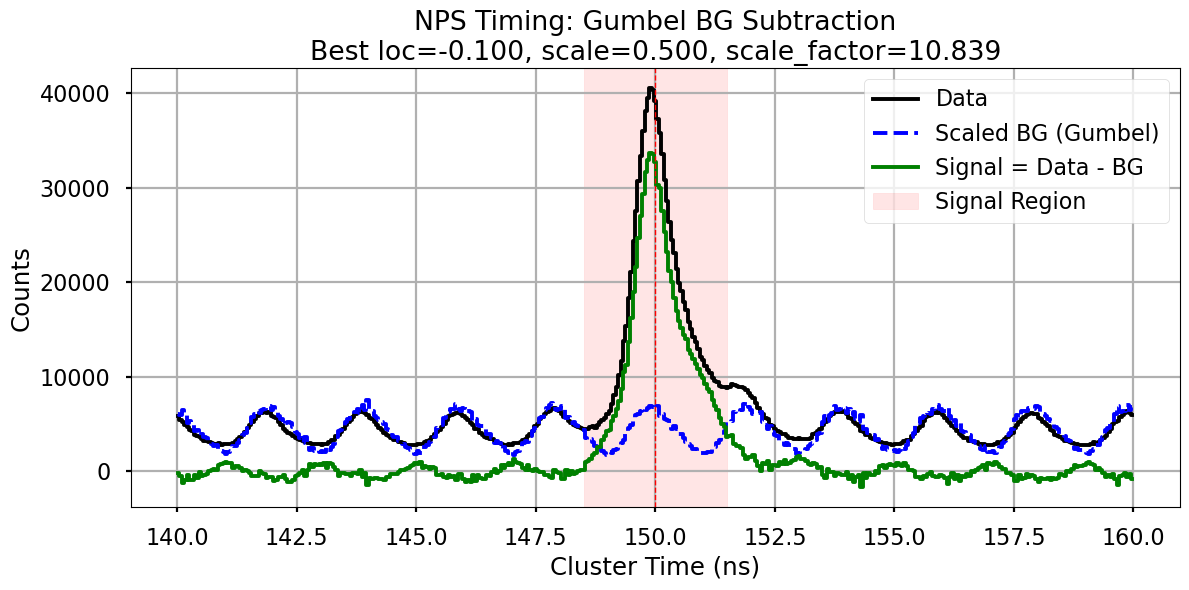

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
from scipy.optimize import minimize
import awkward as ak  # Needed if your data uses Awkward Arrays

# === Load Real Cluster Time Data ===
clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))  # Replace with your branch

# === Constants ===
beam_bucket_spacing = 2.0        # ns
n_buckets = 200
true_peak_time = 150.0           # ns
n_bg_per_bucket = 16000

# === Histogram Binning ===
bins = np.linspace(140, 160, 400)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# === Sideband Mask ===
sideband_mask = ((bin_centers < 148.5) | (bin_centers > 151.5))

# === Helper to Simulate Background ===
def simulate_bg(loc, scale):
    bg_times = []
    for i in range(-n_buckets, n_buckets + 1):
        t_bucket = true_peak_time + i * beam_bucket_spacing
        bg_times.extend(t_bucket + gumbel_r.rvs(loc=loc, scale=scale, size=n_bg_per_bucket))
    return np.array(bg_times)

# === Cost Function for Optimization ===
hist_data, _ = np.histogram(clusT, bins=bins)

def sideband_chi2(params):
    loc, scale = params
    bg_sim = simulate_bg(loc, scale)
    hist_bg, _ = np.histogram(bg_sim, bins=bins)
    
    data_sb = hist_data[sideband_mask]
    bg_sb = hist_bg[sideband_mask]

    # Normalize background to data in sidebands
    scale_factor = np.sum(data_sb) / np.sum(bg_sb) if np.sum(bg_sb) > 0 else 1.0
    bg_sb_scaled = bg_sb * scale_factor
    
    # Chi² between data and scaled background in sidebands
    chi2 = np.sum((data_sb - bg_sb_scaled)**2 / (data_sb + 1e-6))  # avoid /0
    return chi2

# === Minimize to Find Best loc and scale ===
result = minimize(sideband_chi2, x0=[-0.1, 0.5], bounds=[(-1, 1), (0.2, 2.0)])
best_loc, best_scale = result.x

# === Final Simulation with Best Parameters ===
final_bg = simulate_bg(best_loc, best_scale)
hist_bg_final, _ = np.histogram(final_bg, bins=bins)

# === Rescale Background to Match Sidebands ===
data_sb_sum = np.sum(hist_data[sideband_mask])
bg_sb_sum = np.sum(hist_bg_final[sideband_mask])
scale_factor = data_sb_sum / bg_sb_sum if bg_sb_sum > 0 else 1.0
scaled_bg = hist_bg_final * scale_factor

# === Subtract Background ===
subtracted = hist_data - scaled_bg

# === Plot Combined ===
plt.figure(figsize=(12, 6))

plt.step(bin_centers, hist_data, where='mid', color='black', label='Data')
plt.step(bin_centers, scaled_bg, where='mid', color='blue', linestyle='--', label='Scaled BG (Gumbel)')
plt.step(bin_centers, subtracted, where='mid', color='green', label='Signal = Data - BG')
plt.axvspan(148.5, 151.5, color='red', alpha=0.1, label='Signal Region')
plt.axvline(true_peak_time, color='red', linestyle='--', linewidth=1)
plt.xlabel("Cluster Time (ns)")
plt.ylabel("Counts")
plt.title(f"NPS Timing: Gumbel BG Subtraction\nBest loc={best_loc:.3f}, scale={best_scale:.3f}, scale_factor={scale_factor:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

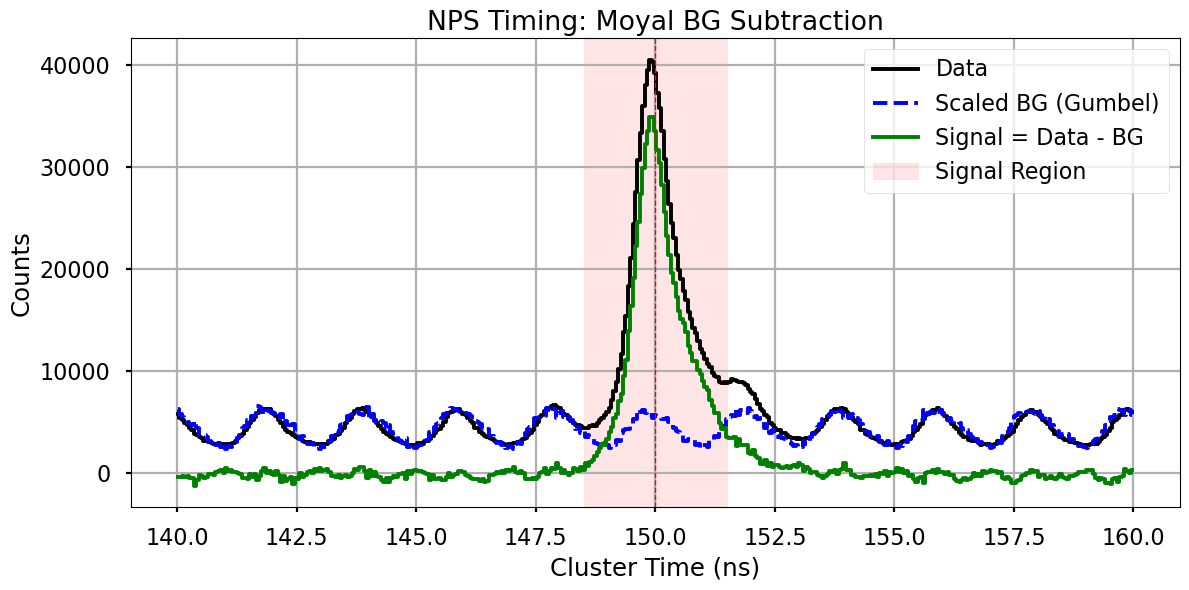

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
from scipy.interpolate import interp1d
from scipy.stats import landau
from scipy.stats import moyal

# === Load real data ===
# Replace this with your real NPS cluster time data
# Example: cluster_times = branches["NPS.cal.clusT"][has_two_clust].to_numpy()
# cluster_times = np.loadtxt("your_data_times.txt")  # Replace with your actual data source
clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
# === Parameters ===
beam_bucket_spacing = 2.0        # ns
n_buckets = 200                  # Simulate +/- 200 buckets (~400 ns window)
true_peak_time = 150.0           # ns, main coincidence
timing_resolution = 0.4          # ns (Gaussian sigma)
n_true_events = 100000             # Number of true coincidences
n_bg_per_bucket = 16000             # Background events per beam bucket

# === Histogram bins ===
bins = np.linspace(140, 160, 400)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# === Simulate background ===
bg_times = []
for i in range(-n_buckets, n_buckets + 1):
    t_bucket = true_peak_time + i * beam_bucket_spacing
    # bg_cluster_times = landau.rvs(loc=t_bucket, scale=timing_resolution, size=n_bg_per_bucket)
    bg_cluster_times = moyal.rvs(loc=t_bucket-0.119, scale=timing_resolution, size=n_bg_per_bucket)
    bg_times.extend(bg_cluster_times)

bg_times = np.array(bg_times)

# === Normalize background using sidebands ===
hist_data, _ = np.histogram(clusT, bins=bins)
hist_bg, _ = np.histogram(bg_times, bins=bins)

# Define sidebands (away from signal region)
sideband_mask = ((bin_centers < 148.5) | (bin_centers > 151.5))

# Calculate scale factor using sidebands
data_sb_sum = np.sum(hist_data[sideband_mask])
sim_sb_sum = np.sum(hist_bg[sideband_mask])
scale_factor = data_sb_sum / sim_sb_sum if sim_sb_sum > 0 else 0

# Scale background
scaled_bg = hist_bg * scale_factor

# === Background Subtracted Histogram ===
subtracted = hist_data - scaled_bg

# === Plotting ===
# plt.figure(figsize=(8, 5))

# plt.step(bin_centers, hist_data, where='mid', color='black', label='Data')
# plt.step(bin_centers, scaled_bg, where='mid', color='blue', linestyle='--', label='Simulated BG (scaled)')
# plt.axvspan(148.5, 151.5, color='red', alpha=0.1, label='Signal Region')
# plt.xlabel("Cluster Time (ns)")
# plt.ylabel("Counts")
# plt.title("Data and Simulated Gumbel Background")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.step(bin_centers, subtracted, where='mid', color='green', label='Data - BG')
# plt.axhline(0, color='gray', linestyle='--')
# plt.xlabel("Cluster Time (ns)")
# plt.ylabel("Signal Estimate (Counts)")
# plt.title("Background Subtracted Signal")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(12, 6))

plt.step(bin_centers, hist_data, where='mid', color='black', label='Data')
plt.step(bin_centers, scaled_bg, where='mid', color='blue', linestyle='--', label='Scaled BG (Gumbel)')
plt.step(bin_centers, subtracted, where='mid', color='green', label='Signal = Data - BG')
plt.axvspan(148.5, 151.5, color='red', alpha=0.1, label='Signal Region')
plt.axvline(true_peak_time, color='red', linestyle='--', linewidth=1)
plt.xlabel("Cluster Time (ns)")
plt.ylabel("Counts")
# plt.title(f"NPS Timing: Landau BG Subtraction\nBest loc={loc:.3f}, scale={scale:.3f}, scale_factor={scale_factor:.3f}")
plt.title(f"NPS Timing: Moyal BG Subtraction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

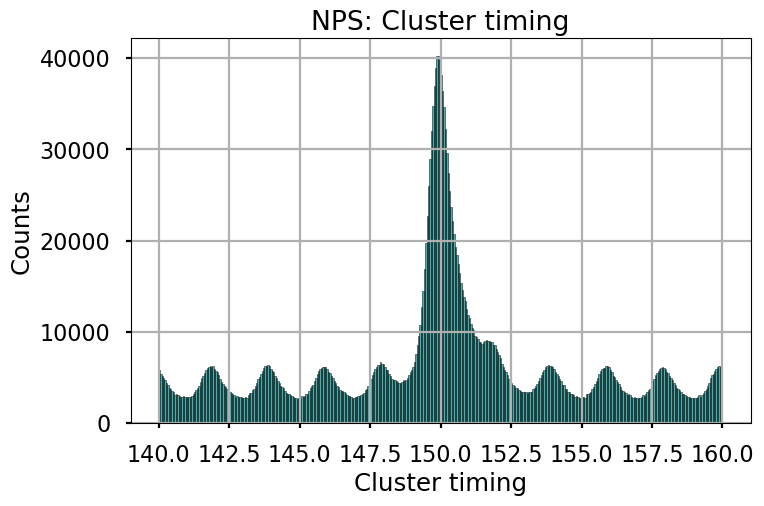

In [102]:
# includes all the cluster instances associated to the events.

plt.figure(figsize=(8,5))
plt.hist(clusT, bins=400, density=False, range=(140,160), color="darkcyan", edgecolor="black", alpha=0.7)
plt.xlabel("Cluster timing")
plt.ylabel("Counts")
plt.title("NPS: Cluster timing")
plt.grid(True)
plt.show()

# Missing mass reconstruction 

# 🧭 Coordinate Transformations in Hall C (Jefferson Lab)

This notebook uses a series of rotations to transform momentum vectors between coordinate systems used in Hall C:

## 🔁 Coordinate Systems

| System                  | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| **Hall (h)**           | Global frame:  
                         - \(+z_h\): along beam direction  
                         - \(+x_h\): beam-left  
                         - \(+y_h\): vertical up (ceiling) |
| **Spectrometer (s)**   | Aligned with spectrometer central ray:  
                         - \(+z_s\): along spectrometer axis (rotated by θ)  
                         - \(+x_s\): dispersive (toward floor)  
                         - \(+y_s\): non-dispersive (beam-left) |
| **Detector Hut (d)**   | Local detector frame:  
                         - Rotated from spectrometer frame by 25° about \(y_s\)  
                         - \(+z_d\): along dipole bend direction |

---

## 🔄 HMS Electron: Detector Hut → Hall Coordinates

For HMS (to right of beam), apply **inverse rotations**:

1. **Rotate +25° about y-axis**  
   → detector hut → spectrometer  
   `rotate_y(p_vec, 25)`

2. **Rotate +90° about z-axis**  
   → spectrometer → intermediate (undo -90°)  
   `rotate_z(p_spec, 90)`

3. **Rotate +θ about y-axis**  
   → undo spectrometer central angle (e.g., θ = 19.36°)  
   `rotate_y(p_spec, theta_deg)`

---

## 🔄 NPS Photon: Spectrometer → Hall Coordinates

For NPS (to left of beam), apply:

1. **Rotate +90° about z-axis**  
   → spectrometer → intermediate  
   `rotate_z(p_vec, 90)`

2. **Rotate −θ about y-axis**  
   → undo spectrometer angle (e.g., θ = 17.5°)  
   `rotate_y(p_spec, -theta_deg)`

---

## 🧮 Detector Hut Origin Offset

The origin of the detector hut system is **offset** from the Hall origin by distance **L** along the spectrometer axis:

```python
def detector_origin_in_hall(L, theta_deg):
    x = L * sin(θ)
    z = L * cos(θ)


In [7]:
# passive transformations since the coordinate system is being rotated; COUNTER/ANTI CLOCKWISE rotation of axes
def rotate_x(vec, theta_deg):
    theta = np.radians(theta_deg)
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta), np.sin(theta)],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return Rx @ vec

def rotate_y(vec, theta_deg): 
    theta = np.radians(theta_deg)
    Ry = np.array([
        [np.cos(theta), 0, -np.sin(theta)],
        [0, 1, 0],
        [np.sin(theta), 0, np.cos(theta)]
    ])
    return Ry @ vec

def rotate_z(vec, theta_deg):
    theta = np.radians(theta_deg)
    Rz = np.array([
        [np.cos(theta), np.sin(theta), 0],
        [-np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return Rz @ vec

def detector_origin_in_hall(L, theta_deg):
    theta = np.radians(theta_deg)
    x = L * np.sin(theta)
    y = 0
    z = L * np.cos(theta)
    return np.array([x, y, z])


def detector_hut_to_hall(px, py, pz, theta_deg): #HMS to the right of beamline
    # Compose all inverse rotations
    p_vec = np.array([px, py, pz])
    # p_spec = rotate_y(p_vec, -25)         # Detector → Spectrometer # this one has to be an active rotation as the electron vector is "artificially bent" for the spectrometer.
    #artificial because that's not because of the scattering. not needed as bothe the coordinate axes and the electron vector are rotated.
    p_spec = rotate_z(p_vec, 90)        # Spec → Hall (undo -90°)
    p_hall = rotate_y(p_spec, theta_deg)  # Undo spectrometer angle θ
    return p_hall

def nps_to_hall(px, py, pz, theta_deg): #NPS to the left of beamline
    # Compose all inverse rotations
    p_vec = np.array([px, py, pz])
    # p_hall = rotate_z(p_vec, 90)        # Spec → Hall (undo -90°)
    p_hall = rotate_y(p_vec, theta_deg)  # Undo spectrometer angle θ

    # p_hall = rotate_y(np.array([px, py, pz]), theta_deg)
    # # Step 2: Undo rotation from detector to spectrometer (rotate around Z by -90°)
    # p_hall = rotate_z(p_hall, -90)
    return p_hall

# def detector_hut_to_hall_with_translation(px, py, pz, L=18.1, theta_deg=16.5): # check units of L
#     # 1. Rotate from detector hut to hall
#     p_rot = detector_hut_to_hall(px, py, pz, theta_deg)

#     # 2. Translate from detector hut origin to hall origin
#     origin_shift = detector_origin_in_hall(L, theta_deg)

#     # 3. Return full momentum vector (no need to shift momentum itself, but position vectors would be shifted)
#     return p_rot  # Use origin_shift if you're dealing with positions


In [ ]:
# --- HMS and NPS cut helpers ---
def pass_hms_cuts(edt, dp, etrnorm, npe, th, ph):
    return (edt < 0.1 and abs(dp) <= 8.5 and abs(etrnorm - 1) < 0.1 and npe > 1.0 and
            abs(th) <= 0.09 and abs(ph) <= 0.09)

def is_good_cluster(e, t, x, y):
    return (e >= 0.6 and 148 <= t <= 152 and
            -29.16 < x < 29.16 and -35.64 < y < 35.64)

def get_photon_4vector(E, x, y, z_nps=407): #z_nps in cm
    r = np.array([x, y, z_nps])
    u = r / np.linalg.norm(r)
    p = E * u
    return np.array([E, *p])

def check_opening_angle(e1, e2, x1, y1, x2, y2, z_nps=407): # z_nps in cm
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    norm1 = np.sqrt(np.sum(r1 ** 2))
    norm2 = np.sqrt(np.sum(r2 ** 2))
    u1 = r1 / norm1
    u2 = r2 / norm2

    # Opening angle cut
    s = 4 * e1 * e2
    arg = M_PION0 / np.sqrt(s)
    if arg < -1 or arg > 1:
        return False  # reject unphysical event
    theta_ideal = 2 * np.arcsin(arg)

    # theta_ideal = 2 * np.arcsin(M_PION0 / np.sqrt(4 * e1 * e2))
    dot = np.dot(u1, u2)
    dot = min(1.0, max(-1.0, dot))  # Clamp to avoid NaNs from rounding errors
    theta_data = np.arccos(dot)


    # block_dim = 0.0205 # 2.05 x 2.05 cm^2 PbWO4 scintillator block
    theta_tolerance_rad = 0.02 # considering a cluster size of 4x4 blocks and the distance of NPS of 4.07 m. theta = (4x0.0205)/nps_distance

    if np.abs(theta_data - theta_ideal) < theta_tolerance_rad:  # radians
        return 1
    

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import numba as nb
import pandas as pd
from tqdm import tqdm

# Constants
m_e = 0.000511
m_p = 0.938
E_beam = 10.537  # GeV
z_nps = 407     # cm

# @nb.njit

# Beam and target 4-vectors in lab frame
p4_ein = np.array([E_beam, 0, 0, E_beam])
p4_pin = np.array([m_p, 0, 0, 0])

# Event selection: ≥2 clusters
has_two_clust = ak.num(branches["NPS.cal.clusE"]) >= 2

# Extract variables (only for selected events)
edt  = ak.to_numpy(branches["T.hms.hEDTM_tdcTimeRaw"])[has_two_clust]
dp   = ak.to_numpy(branches["H.gtr.dp"])[has_two_clust]
et   = ak.to_numpy(branches["H.gtr.p"])[has_two_clust] # using momentum as the energy
etrnorm = ak.to_numpy(branches["H.cal.etracknorm"])[has_two_clust]
npe  = ak.to_numpy(branches["H.cer.npeSum"])[has_two_clust]
th   = ak.to_numpy(branches["H.gtr.th"])[has_two_clust]
ph   = ak.to_numpy(branches["H.gtr.ph"])[has_two_clust]
pe   = ak.to_numpy(branches["H.gtr.p"])[has_two_clust]
px_e = ak.to_numpy(branches["H.gtr.px"])[has_two_clust]
py_e = ak.to_numpy(branches["H.gtr.py"])[has_two_clust]
pz_e = ak.to_numpy(branches["H.gtr.pz"])[has_two_clust]
Ee   = ak.to_numpy(branches["H.gtr.p"])[has_two_clust] # using momentum as the energy

# Cluster info (still jagged arrays)
clusE = branches["NPS.cal.clusE"][has_two_clust]
clusX = branches["NPS.cal.clusX"][has_two_clust]
clusY = branches["NPS.cal.clusY"][has_two_clust]
clusT = branches["NPS.cal.clusT"][has_two_clust]

missing_mass = []
# Loop over events
# for i in range(len(pe)):
for i in tqdm(range(len(pe)), desc="Processing events"):
    # if not pass_hms_cuts(edt[i], dp[i], et[i], npe[i], th[i], ph[i]):
    #     continue
    if Ee[i] < 3.5:
        continue
# transforming from HMS detector hut coordinates to hall coordinates
    # p_hall = detector_hut_to_hall(px_e[i], py_e[i], pz_e[i], theta_deg=19.36)
    # px_ehall, py_ehall, pz_ehall = p_hall[0], p_hall[1], p_hall[2]

    # # Scattered electron 4-vector
    # # p4_eout = np.array([Ee[i], px_ehall[i], py_ehall[i], pz_ehall[i]])
    # p4_eout = np.array([Ee[i], px_ehall, py_ehall, pz_ehall])

    # Get this event's clusters

    p4_eout = np.array([
        Ee[i],                          # energy
        px_e[i],                  # px
        py_e[i],                  # py
        pz_e[i]  # pz
    ])    
    # p4_eout = np.array([
    #     Ee[i],                          # energy
    #     Ee[i] * ph[i],                  # px
    #     Ee[i] * th[i],                  # py
    #     Ee[i] * (1.0 - 0.5*(th[i]**2 + ph[i]**2))  # pz
    # ])


    e_arr = np.array(clusE[i])
    x_arr = np.array(clusX[i])
    y_arr = np.array(clusY[i])
    t_arr = np.array(clusT[i])

    if len(e_arr) < 2:
        continue

    # Sort cluster indices by energy (descending)
    idx = np.argsort(e_arr)[-2:]

    # Select two most energetic clusters
    e1, e2 = e_arr[idx[1]], e_arr[idx[0]]
    x1, x2 = x_arr[idx[1]], x_arr[idx[0]]
    y1, y2 = y_arr[idx[1]], y_arr[idx[0]]
    t1, t2 = t_arr[idx[1]], t_arr[idx[0]]

    # if not (is_good_cluster(e1, t1, x1, y1) and is_good_cluster(e2, t2, x2, y2)):
    #     continue



    if not pass_hms_cuts(edt[i], dp[i], etrnorm[i], npe[i], th[i], ph[i]):
        continue
    if not check_opening_angle(e1, e2, x1, y1, x2, y2):
        continue

    if not (is_good_cluster(e1, t1, x1, y1) & is_good_cluster(e2, t2, x2, y2)):
        continue







    # π⁰ 4-vector from 2 photons
    # Build photon 4-vectors in hall frame individually
    photon1 = get_photon_4vector(e1, x1, y1)
    photon2 = get_photon_4vector(e2, x2, y2)

    # Rotate photon momenta to hall frame
    # NPS to the left of beam thus require a CLOCKWISE rotation of axes
    p1x, p1y, p1z = nps_to_hall(photon1[1], photon1[2], photon1[3], theta_deg=-17.51) 
    p2x, p2y, p2z = nps_to_hall(photon2[1], photon2[2], photon2[3], theta_deg=-17.51)

    # Construct full 4-vectors
    p4_ph1 = np.array([photon1[0], p1x, p1y, p1z])
    p4_ph2 = np.array([photon2[0], p2x, p2y, p2z])

    # Add to get pion
    p4_pi = p4_ph1 + p4_ph2

    # p4_pi = photon1 + photon2


    # Final state and missing 4-momentum
    p4_out = p4_eout + p4_pi
    p4_miss = (p4_ein + p4_pin) - p4_out
    m2_miss = p4_miss[0]**2 - np.dot(p4_miss[1:], p4_miss[1:])
    # if m2_miss < -1:
    #     temp1 = p4_pi[0]**2 - np.dot(p4_pi[1:], p4_pi[1:])
    #     temp2 = p4_pin[0]**2 - np.dot(p4_pin[1:], p4_pin[1:])
    #     temp3 = p4_ein[0]**2 - np.dot(p4_ein[1:], p4_ein[1:])
    #     temp4 = p4_eout[0]**2 - np.dot(p4_eout[1:], p4_eout[1:])
    #     print(f"incoming electron: {np.sqrt(temp3)}, incoming proton: {np.sqrt(temp2)}, scattered electron^2: {temp4}, pion: {np.sqrt(temp1)}")
        # print(f"total in: {p4_ein + p4_pin}, square: {(p4_ein + p4_pin)[0]**2 - (p4_ein + p4_pin)[3]**2}")
        # print(f"eout unrotated: {Ee[i], px_e[i], py_e[i], pz_e[i]}, square: {Ee[i]**2 - px_e[i]**2 - py_e[i]**2 - pz_e[i]**2}")
        # print(f"eout 4vec: {p4_eout}, square: {p4_eout[0]**2 - p4_eout[1]**2 - p4_eout[2]**2 - p4_eout[3]**2}")
        # print(f"pi 4vec:   {p4_pi}, square root: {np.sqrt(p4_pi[0]**2 - p4_pi[1]**2 - p4_pi[2]**2 - p4_pi[3]**2)}")
        # print(f"total out: {p4_out}, square: {p4_out[0]**2 - p4_out[1]**2 - p4_out[2]**2 - p4_out[3]**2}")
        # print(f"miss 4vec: {p4_miss}")
        # print(f"m²_miss:   {m2_miss:.4f}")
    #     print(f"photons original: {photon1}; {photon2}")




        # print(f"BAD m²_miss = {m2_miss:.2f}, px={p4_out[1]:.2f}, py={p4_out[2]:.2f}, pz={p4_out[3]:.2f}")

    # print(m2_miss)
    # m_miss = np.sqrt(m2_miss) if m2_miss > 0 else 0
    missing_mass.append(m2_miss)
    df = pd.DataFrame(missing_mass)
    df.to_csv("missing_mass_sq.csv", mode = 'w', index=False)

Processing events:   0%|          | 0/1867180 [00:00<?, ?it/s]/tmp/ipykernel_105901/1046501521.py:75: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e_arr = np.array(clusE[i])
/tmp/ipykernel_105901/1046501521.py:76: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_arr = np.array(clusX[i])
/tmp/ipykernel_105901/1046501521.py:77: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' 

/tmp/ipykernel_105901/2448041398.py:11: RuntimeWarning: invalid value encountered in sqrt
  hist_vals, bin_edges = np.histogram(np.sqrt(missing_mass), bins=bins)
/tmp/ipykernel_105901/2448041398.py:32: RuntimeWarning: invalid value encountered in sqrt
  plt.hist(np.sqrt(missing_mass), bins=100, range=(0.5, 2.5), color='steelblue', alpha=0.75, label="Data")


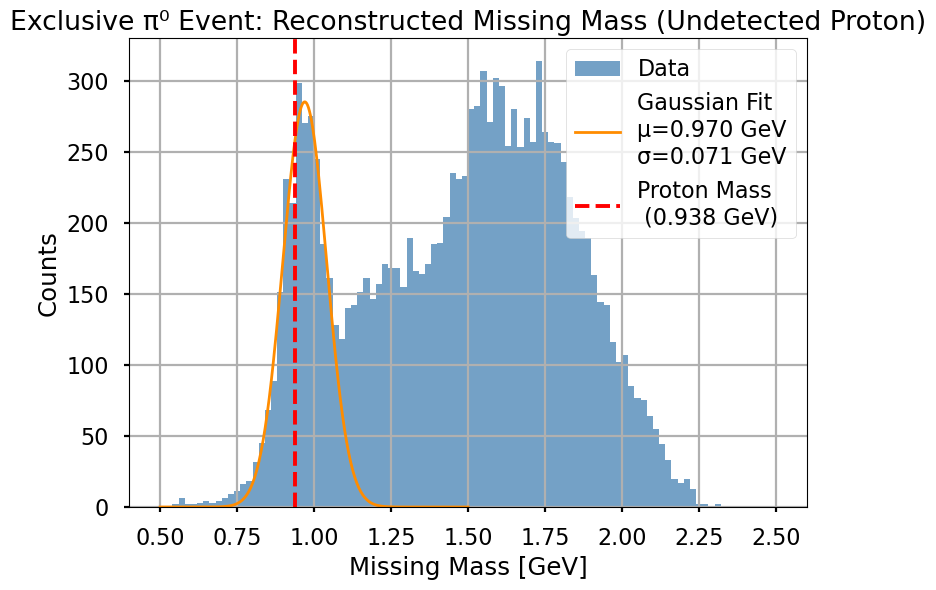

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Define binning
bins = np.linspace(0.5, 2.5, 101)
hist_vals, bin_edges = np.histogram(np.sqrt(missing_mass), bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit range near proton mass (0.85 to 1.05 GeV)
fit_mask = (bin_centers > 0.8) & (bin_centers < 1.02)
x_fit = bin_centers[fit_mask]
y_fit = hist_vals[fit_mask]

# Initial guesses: [Amplitude, Mean, Sigma]
p0 = [np.max(y_fit), 0.938, 0.02]

# Fit the Gaussian
popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
A_fit, mu_fit, sigma_fit = popt

# Generate fitted curve
x_smooth = np.linspace(0.5, 1.5, 300)
y_smooth = gaussian(x_smooth, *popt)

# Plot histogram and fit
plt.figure(figsize=(8, 6))
plt.hist(np.sqrt(missing_mass), bins=100, range=(0.5, 2.5), color='steelblue', alpha=0.75, label="Data")
plt.plot(x_smooth, y_smooth, color='darkorange', lw=2, label=f"Gaussian Fit\nμ={mu_fit:.3f} GeV\nσ={sigma_fit:.3f} GeV")
plt.axvline(m_p, color='red', linestyle='--', label='Proton Mass \n (0.938 GeV)')
plt.xlabel("Missing Mass [GeV]")
plt.ylabel("Counts")
plt.title("Exclusive π⁰ Event: Reconstructed Missing Mass (Undetected Proton)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


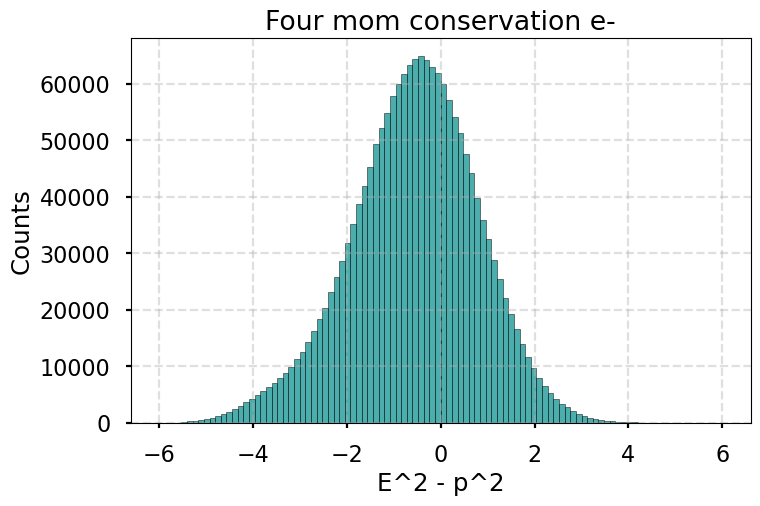

1762730

In [32]:
# Extract variables (only for selected events)
edt  = ak.to_numpy(branches["T.hms.hEDTM_tdcTimeRaw"])
dp   = ak.to_numpy(branches["H.gtr.dp"])
et   = ak.to_numpy(branches["H.cal.etracknorm"])
npe  = ak.to_numpy(branches["H.cer.npeSum"])
th   = ak.to_numpy(branches["H.gtr.th"])
ph   = ak.to_numpy(branches["H.gtr.ph"])
pe   = ak.to_numpy(branches["H.gtr.p"])
px_e = ak.to_numpy(branches["H.gtr.px"])
py_e = ak.to_numpy(branches["H.gtr.py"])
pz_e = ak.to_numpy(branches["H.gtr.pz"])
Ee   = ak.to_numpy(branches["H.cal.etrack"])

mass_sq = []

for i in range(len(pe)):
  if edt[i] < 0.1 and abs(dp[i]) <= 8.5 and et[i] > 0.9 and npe[i] > 1.0 and abs(th[i]) <= 0.09 and abs(ph[i]) <= 0.09:
            mass_sq.append(Ee[i]**2 - pe[i]**2)

plt.figure(figsize=(8, 5))
plt.hist(mass_sq, bins=100, range = (-6,6), color="darkcyan", edgecolor="black", alpha=0.7)
plt.xlabel("E^2 - p^2")
plt.ylabel("Counts")
plt.title("Four mom conservation e-")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()
len(mass_sq)

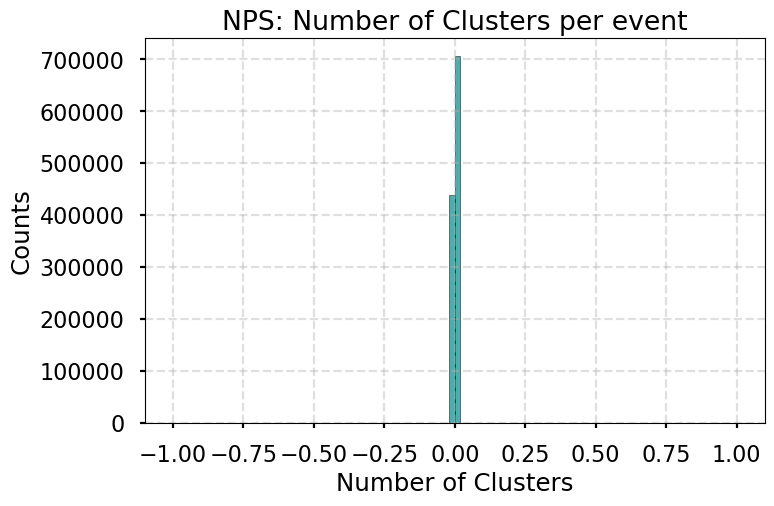

In [ ]:
temptemp = ak.to_numpy(branches["H.gtr.p"]**2 - branches["H.gtr.px"]**2 - branches["H.gtr.py"]**2 - branches["H.gtr.pz"]**2)
plt.figure(figsize=(8, 5))
plt.hist(temptemp, bins=100, range = (-1,1), color="darkcyan", edgecolor="black", alpha=0.7)
plt.xlabel("Number of Clusters")
plt.ylabel("Counts")
plt.title("NPS: Number of Clusters per event")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [79]:
# # includes all the cluster instances associated to the events.

# clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))

# plt.figure(figsize=(8,5))
# plt.hist(clusT, bins=150, range=(140,160), color="darkcyan", edgecolor="black", alpha=0.7)
# plt.xlabel("Cluster timing")
# plt.ylabel("Counts")
# plt.title("NPS: Cluster timing")
# plt.show()

import awkward as ak
# First filter for events with two clusters
clusT = branches["NPS.cal.clusT"][has_two_clust]
clusE = branches["NPS.cal.clusE"][has_two_clust]

# Apply cuts
energy_cut = clusE > 0.6
time_cut = (clusT > 145) & (clusT < 155)

# Combined cut (both energy and timing)
combined_cut = energy_cut & time_cut

# Apply combined cut to time branch
clusT_temp = clusT[combined_cut]



In [80]:
clus_temp

<Array [[149], [], [], ..., [171], [115, 144]] type='1867180 * var * float64'>